In [1]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns

In [2]:
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

stockname = 'RYE'

In [3]:
# Import Data from CSV file
df = pd.read_csv("Resources/Data_Consolidated.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Oil_Close
0,2010-01-04,45.049999,52.000000,45.049999,52.000000,42.399708,31200,79.05
1,2010-01-05,53.009998,53.029999,52.360001,53.020000,43.231415,2700,79.27
2,2010-01-06,52.910000,54.009998,52.910000,53.849998,43.908169,13400,80.14
3,2010-01-07,53.610001,53.799999,53.000000,53.790001,43.859241,2800,80.57
4,2010-01-08,53.590000,54.200001,53.549999,54.200001,44.193558,4300,80.06


In [ ]:
# Set up Date as index
df.set_index('Date')

In [4]:
# Drop Null values
df = df.dropna()
df

,Date,Open,High,Low,Close,Adj Close,Volume,Oil_Close
0,2010-01-04,45.049999,52.000000,45.049999,52.000000,42.399708,31200,79.05
1,2010-01-05,53.009998,53.029999,52.360001,53.020000,43.231415,2700,79.27
2,2010-01-06,52.910000,54.009998,52.910000,53.849998,43.908169,13400,80.14
3,2010-01-07,53.610001,53.799999,53.000000,53.790001,43.859241,2800,80.57
4,2010-01-08,53.590000,54.200001,53.549999,54.200001,44.193558,4300,80.06
...,...,...,...,...,...,...,...,...
3075,2022-03-22,66.220001,66.410004,64.980003,65.849998,65.849998,115300,99.29
3076,2022-03-23,66.839996,67.610001,66.720001,67.160004,67.160004,135600,101.29
3077,2022-03-24,67.349998,67.809998,66.940002,67.330002,67.330002,115000,98.56
3078,2022-03-25,66.949997,69.059998,66.949997,69.040001,69.040001,287700,103.08


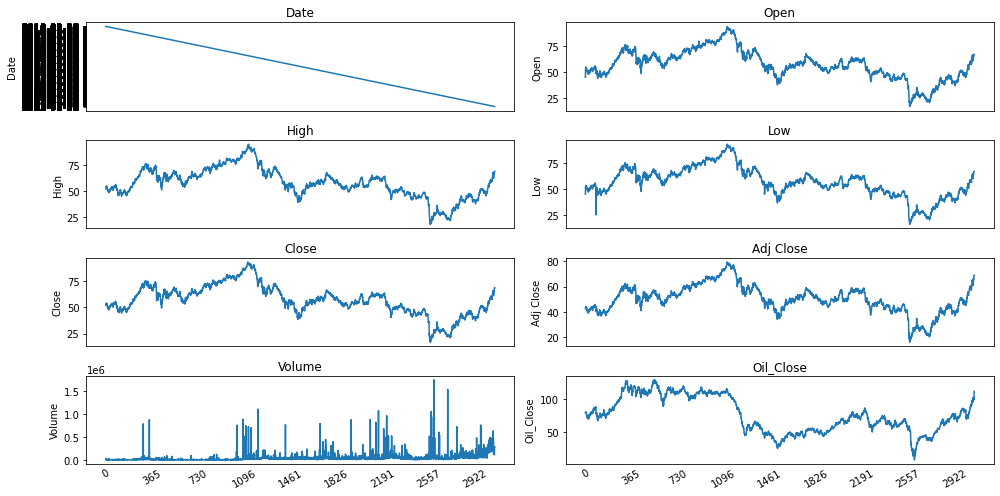

In [5]:
# Plot line charts
df_plot = df.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [6]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
#d = pd.to_datetime(train_df.index)
#train_df['Month'] = d.strftime("%m")
#train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Oil_Close
0,2010-01-04,45.049999,52.000000,45.049999,52.000000,42.399708,31200,79.05
1,2010-01-05,53.009998,53.029999,52.360001,53.020000,43.231415,2700,79.27
2,2010-01-06,52.910000,54.009998,52.910000,53.849998,43.908169,13400,80.14
3,2010-01-07,53.610001,53.799999,53.000000,53.790001,43.859241,2800,80.57
4,2010-01-08,53.590000,54.200001,53.549999,54.200001,44.193558,4300,80.06


In [7]:
# List of considered Features
FEATURES = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Oil_Close' 
           ]           

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Oil_Close']


,Open,High,Low,Close,Adj Close,Volume,Oil_Close,Prediction
3075,66.220001,66.410004,64.980003,65.849998,65.849998,115300,99.29,65.849998
3076,66.839996,67.610001,66.720001,67.160004,67.160004,135600,101.29,67.160004
3077,67.349998,67.809998,66.940002,67.330002,67.330002,115000,98.56,67.330002
3078,66.949997,69.059998,66.949997,69.040001,69.040001,287700,103.08,69.040001
3079,66.949997,69.058998,67.050003,69.040001,69.040001,287745,110.93,69.040001


In [8]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3080, 7)


In [9]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2414, 50, 7) (2414,)
(616, 50, 7) (616,)
0.4421482285678824
0.4421482285678824


In [10]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

350 50 7


In [11]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/50
151/151 [==============================] - 34s 211ms/step - loss: 0.0058 - val_loss: 0.0027
Epoch 2/50
151/151 [==============================] - 30s 198ms/step - loss: 7.8877e-04 - val_loss: 0.0015
Epoch 3/50
151/151 [==============================] - 32s 210ms/step - loss: 7.1179e-04 - val_loss: 9.8574e-04
Epoch 4/50
151/151 [==============================] - 35s 232ms/step - loss: 5.7999e-04 - val_loss: 0.0010
Epoch 5/50
151/151 [==============================] - 34s 227ms/step - loss: 6.6225e-04 - val_loss: 9.7266e-04
Epoch 6/50
151/151 [==============================] - 34s 224ms/step - loss: 4.8217e-04 - val_loss: 6.9009e-04
Epoch 7/50
151/151 [==============================] - 34s 223ms/step - loss: 5.3640e-04 - val_loss: 7.4057e-04
Epoch 8/50
151/151 [==============================] - 33s 221ms/step - loss: 4.2027e-04 - val_loss: 6.0401e-04
Epoch 9/50
151/151 [==============================] - 34s 222ms/step - loss: 4.0183e-04 - val_loss: 5.5033e-04
Epoch 10/50
151/1

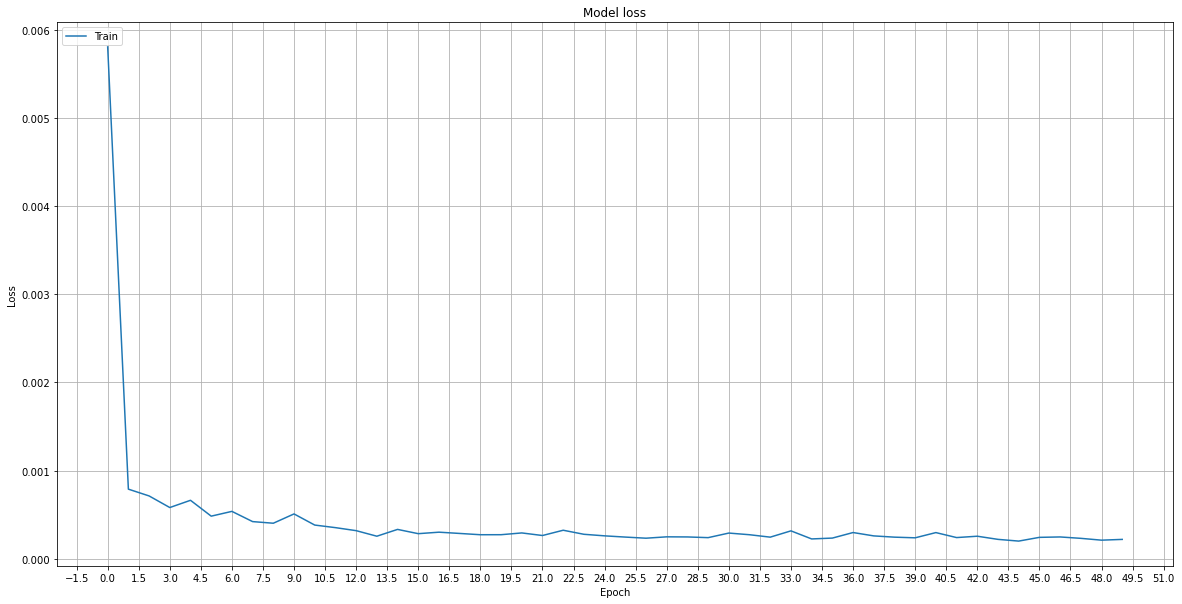

In [12]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [13]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 1.38
Mean Absolute Percentage Error (MAPE): 3.52 %
Median Absolute Percentage Error (MDAPE): 2.71 %


D:\Anaconda\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
D:\Anaconda\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


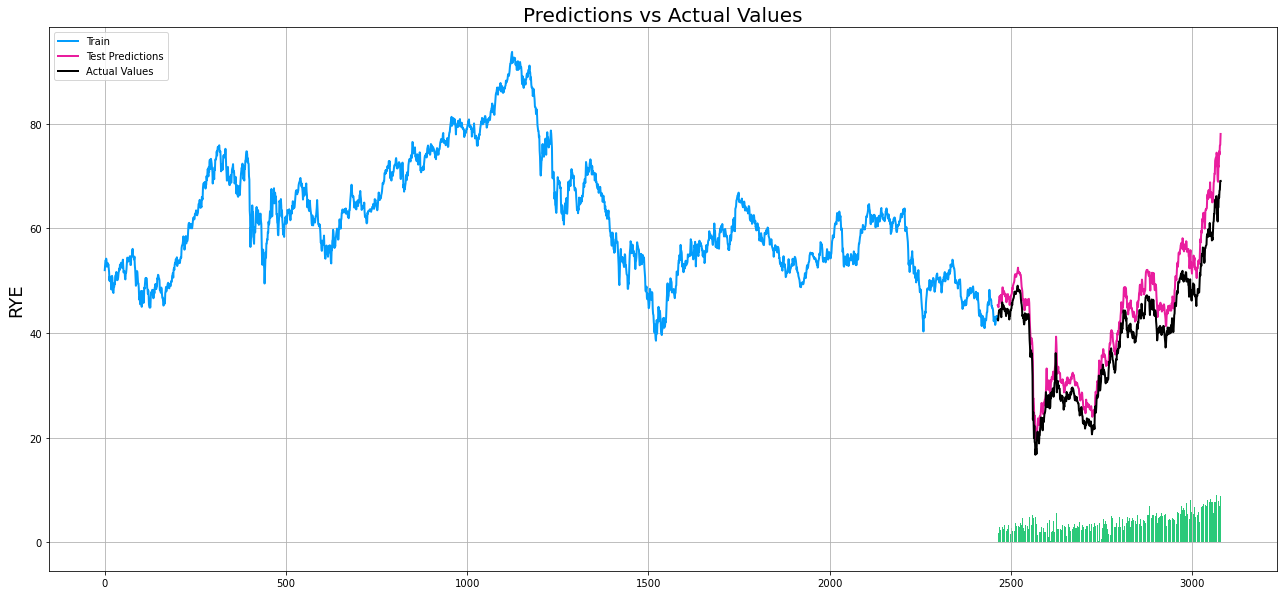

In [16]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe
#valid = valid[valid['Date'] > display_start_date]
#train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

In [20]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

KeyError: -1